# Modelling

## Libraries

In [13]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Read processed data

In [14]:
data = pd.read_csv('../processed_data/out.csv')

## Divide data into train and test set

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop('customer_type', axis=1), data.customer_type, test_size=0.3)

## Encoding function

In [16]:
import category_encoders as ce
class Error(Exception):
    pass
class NonMatchingLengthsError(Error):
    pass

In [17]:
def multiEnc(X_train, X_test, target_train, cols, encodings):
    """
    Lista znaków do "encodings":
        d - backward difference
        n - base N
        b - binary
        c - cat boost
        # - hashing
        h - helmert
        j - James-Stein
        l - leave one out
        m - m-estimate
        1 - one-hot
        o - ordinal
        p - polynomial
        s - sum coding
        t - target encoding
        w - weight of evidence
    """
    ce_map = {"d": ce.backward_difference.BackwardDifferenceEncoder,
             "n": ce.basen.BaseNEncoder,
             "b": ce.binary.BinaryEncoder,
             "c": ce.cat_boost.CatBoostEncoder,
             "#": ce.hashing.HashingEncoder,
             "h": ce.helmert.HelmertEncoder,
             "j": ce.james_stein.JamesSteinEncoder,
             "l": ce.leave_one_out.LeaveOneOutEncoder,
             "m": ce.m_estimate.MEstimateEncoder,
             "1": ce.one_hot.OneHotEncoder,
             "o": ce.ordinal.OrdinalEncoder,
             "p": ce.polynomial.PolynomialEncoder,
             "s": ce.sum_coding.SumEncoder,
             "t": ce.target_encoder.TargetEncoder,
             "w": ce.woe.WOEEncoder}
    try:
        if len(cols)!=len(encodings):
            raise(NonMatchingLengthsError)
    except NonMatchingLengthsError:
        print("Lengths do not match")
        return None
    e=0
    for c in cols:
        if X_train[c].dtypes=='object':
            enc=ce_map[encodings[e]](cols=c)
            enc=enc.fit(X_train, target_train)
            X_train=enc.transform(X_train)
            X_test=enc.transform(X_test)
        e=e+1
    return (X_train, X_test)

In [18]:
# example
#X_train, X_test = multiEnc(X_train, X_test, y_train ,['job'], ['1'])

## Create generic functions to add models and make a Cross-Validation

In [19]:
from abc import (ABC, 
                 abstractmethod, 
                 abstractproperty)
from typing import Any
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier # Inna paczka niż sklearn!
import xgboost as xgb


class Builder(ABC):

    @abstractproperty
    def product(self) -> None:
        pass
    
    
class Product():

    def __init__(self) -> None:
        self.parts = []

    def add(self, part: Any) -> None:
        self.parts.append(part)

    def list_parts(self):
        return self.parts


class ConcreteBuilder(Builder):

    def __init__(self) -> None:

        self.reset()

    def reset(self) -> None:
        self._product = Product()

    @property
    def product(self) -> Product:

        product = self._product
        self.reset()
        return product

    def _add_model(self, model_type: str, params: dict):
        if model_type == 'logistic regression':
            self._logistic_regression(params)
        if model_type == 'decision tree':
            self._decision_tree(params)
        if model_type == 'svm':
            self._svm(params)
        if model_type == 'naive bayes':
            self._naive_bayes(params)
        if model_type == 'random forest':
            self._random_forest(params)
        if model_type == 'ada boost':
            self._ada_boost(params)
        if model_type == 'gradient boost':
            self._gradient_boost(params)
        if model_type == 'xgboost':
            self._xgboost(params)
        
    def _logistic_regression(self, params: dict):
        
        lr = LogisticRegression(**params)
        
        return self._product.add(lr)
    
    def _decision_tree(self, params: dict):
        
        dt = DecisionTreeClassifier(**params)
        
        dt_params = {'criterion': dt.criterion}
        
        return self._product.add(dt)

    def _svm(self, params: dict):
        svm = SVC(**params)
        
        return self._product.add(svm)
    
    def _naive_bayes(self, params: dict):
        nb = GaussianNB(**params)

        return self._product.add(nb)
    
    def _random_forest(self, params: dict):
        
        rf = RandomForestClassifier(**params)
        return self._product.add(rf)
        
    def _ada_boost(self, params: dict):
        ada = AdaBoostClassifier(**params)
    
        return self._product.add(ada)
    
    def _gradient_boost(self, params: dict):
        gb= GradientBoostingClassifier(**params)
        return self._product.add(gb)
    
    def _xgboost(self, params: dict):
        
        xg=XGBClassifier(**params)
        return self._product.add(xg)

class Director:

    def __init__(self) -> None:
        self._builder = None

    @property
    def builder(self) -> Builder:
        return self._builder

    @builder.setter
    def builder(self, builder: Builder) -> None:

        self._builder = builder


    def add_model(self, model_type, params):
        return self.builder._add_model(model_type, params)

    def add_all_models(self):
        self.add_model('logistic regression', {})
        self.add_model('decision tree', {})
        self.add_model('svm', {})
        self.add_model('naive bayes', {})
        self.add_model('random forest', {})
        self.add_model('ada boost', {})
        self.add_model('gradient boost', {})
        self.add_model('xgboost', {})
        return builder.product.list_parts()
    
    def get_all_models(self, metric_name: str = ''):
        parts =  builder.product.list_parts()
        return parts

In [20]:
director = Director()
builder = ConcreteBuilder()
director.builder = builder

## Create different types of models

In [21]:
director.add_model('logistic regression', {'penalty': 'l1', 'fit_intercept': 'False'})

In [22]:
models = director.get_all_models() 

## Evaluate models

In [25]:
from typing import List


def compare_models(models_list: List, X_train, y_train, X_test, y_test, categorical_variables, method):
    results = dict()
    
    df_train, df_test = multiEnc(X_train, X_test, y_train, categorical_variables, len(categorical_variables) * method)
    
    
    for model in models_list:
        
        training = model.fit(df_train, y_train)
        score = training.score(df_test, y_test)
        results[model] = score
        
    return results, df_train, df_test

In [26]:
categorical_variables = ['credit_history', 'purpose', 'personal', 'other_debtors', 'property', 
                        'other_installment_plans', 'housing' , 'job', 'telephone', 'foreign_worker', 
                        'present_employment', 'checking_account_status', 'savings'] 

In [27]:
def save_final_data(X_train, y_train, X_test, y_test, categorical_variables, method):
    df_train, df_test = multiEnc(X_train, X_test, y_train, categorical_variables, len(categorical_variables) * method)
    df_train.to_csv('../final_data/df_train.csv', index=False)
    df_test.to_csv('../final_data/df_test.csv', index=False)
    y_test.to_csv('../final_data/y_test.csv', index=False)
    y_train.to_csv('../final_data/y_train.csv', index=False)

save_final_data(X_train, y_train, X_test, y_test, categorical_variables, '1')


In [33]:
def best_model(results: dict):
    best_model_val = 0

    for key,val in results.items():
        if val > best_model_val:
            best_model = key
            best_model_val = val

    return best_model

In [39]:
from plot_metric.functions import BinaryClassification
from sklearn.metrics import roc_auc_score

def plot_roc(model, df_test, y_test):
    y_pred = model.predict_proba(df_test)[:,1]
    # Visualisation with plot_metric
    bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])

    # Figures
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    plt.show()
    
    print(model, roc_auc_score(y_test, y_pred, average="weighted"))

In [40]:
results, df_train, df_test = compare_models(models, X_train, y_train, X_test, y_test, categorical_variables, '1')
results

{LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept='False',
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l1',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False): 0.7666666666666667}

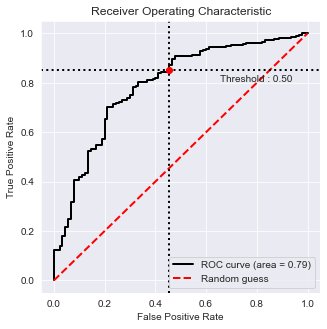

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept='False',
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) 0.7892592592592593


In [42]:
model = best_model(results)
plot_roc(model, df_test, y_test)

## Save models

In [46]:
import pickle

def save_model(model, filename: str):
    pickle.dump(model, open('../models/' + str(filename) + '.sav', 'wb'))

In [48]:
save_model(model, 'LogisticRegression_1')